In [ ]:
!git clone https://github.com/Project-MONAI/MONAI.git
!cd MONAI/
!pip install -e '.[all]'

Cloning into 'MONAI'...
remote: Enumerating objects: 34452, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 34452 (delta 98), reused 134 (delta 75), pack-reused 34259
Receiving objects: 100% (34452/34452), 64.52 MiB | 13.74 MiB/s, done.
Resolving deltas: 100% (27399/27399), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
!pip install "monai[einops]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2023-04-11 19:32:22.319150: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-11 19:32:22.377501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 19:32:23.447340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from monai.utils import first, set_determinism

In [ ]:
import os
import shutil
import tempfile
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.handlers.utils import from_engine
from monai.utils import first
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    Activations,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    RandFlipd,
    RandRotate90d,
    RandAffined,
    RandGaussianNoised,
    RandShiftIntensityd
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR
from monai.apps import download_and_extract

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import torch

In [ ]:
import json
import time
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from monai.utils.enums import MetricReduction
from monai import data
from functools import partial
import glob

print_config()

MONAI version: 1.1.0
Numpy version: 1.22.4
Pytorch version: 2.0.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.9/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.12.1
gdown version: 4.6.6
TorchVision version: 0.15.1+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Setup data directory

In [ ]:
directory = os.environ.get("MONAI_UNETR_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp6nsiygx_


In [ ]:
# Set deterministic training for reproducibility
set_determinism(seed=0)

Setup transforms for training and validation

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
     #augmentation
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        RandAffined(
            keys=['image', 'label'], 
            prob=0.5, 
            translate_range=10
        ),
        RandGaussianNoised(
            keys='image', 
            prob=0.5
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

Download dataset and format in the folder.

In [ ]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [01:37, 16.5MB/s]                            

2023-04-11 19:34:10,819 - INFO - Downloaded: /tmp/tmp6nsiygx_/Task09_Spleen.tar


2023-04-11 19:34:13,874 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-04-11 19:34:13,876 - INFO - Writing into directory: /tmp/tmp6nsiygx_.


In [ ]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]


Setup dataloader

In [ ]:
#Define CacheDataset and DataLoader for training and validation
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4,pin_memory=True)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1,shuffle=False, num_workers=4, pin_memory=True)


Loading dataset: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


image shape: torch.Size([229, 158, 113]), label shape: torch.Size([229, 158, 113])


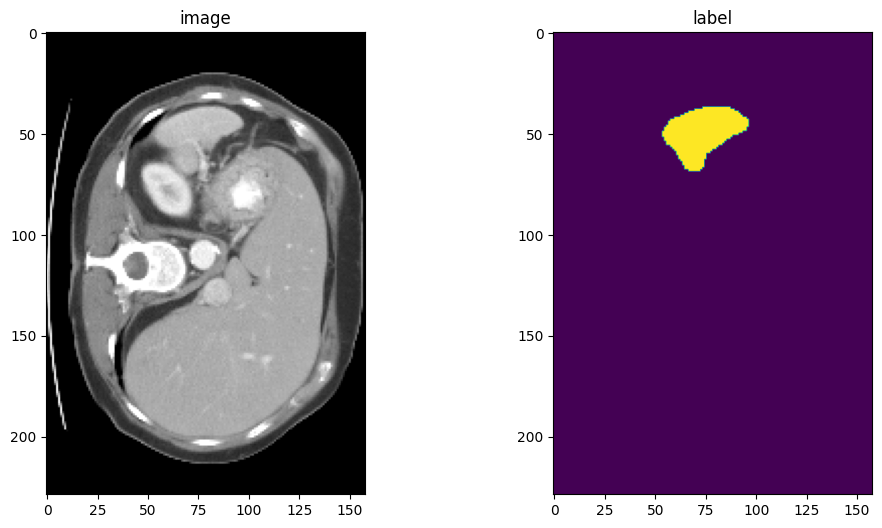

In [ ]:
#Check transforms in DataLoader
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [ ]:
#Create Model, Loss, Optimizer
device = torch.device("cuda:0")
model = UNETR(
    in_channels=1,
    out_channels=2,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

training process

In [ ]:
path='/content/drive/MyDrive/Winter23/deep_learning/final_project/best_models'

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                torch.save(model.state_dict(), os.path.join(path, "unetr_best_metric_model.pth"))

                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (500 / 25000 Steps) (loss=0.69116):  31%|███▏      | 5/16 [00:12<00:37,  3.45s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8499578833580017 Current Avg. Dice: 0.8499578833580017


Training (1000 / 25000 Steps) (loss=0.59131):  56%|█████▋    | 9/16 [00:12<00:16,  2.41s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8735979795455933 Current Avg. Dice: 0.8735979795455933


Training (1500 / 25000 Steps) (loss=0.33521):  81%|████████▏ | 13/16 [00:11<00:05,  1.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8735979795455933 Current Avg. Dice: 0.8703801035881042


Training (2000 / 25000 Steps) (loss=0.44673):   6%|▋         | 1/16 [00:08<02:13,  8.89s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9090543389320374 Current Avg. Dice: 0.9090543389320374


Training (2500 / 25000 Steps) (loss=0.28644):  31%|███▏      | 5/16 [00:10<00:31,  2.88s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9287211894989014 Current Avg. Dice: 0.9287211894989014


Training (3000 / 25000 Steps) (loss=0.26526):  56%|█████▋    | 9/16 [00:12<00:17,  2.51s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9395368099212646 Current Avg. Dice: 0.9395368099212646


Training (3500 / 25000 Steps) (loss=0.38062):  81%|████████▏ | 13/16 [00:11<00:05,  1.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9395368099212646 Current Avg. Dice: 0.928409993648529


Training (4000 / 25000 Steps) (loss=0.25710):   6%|▋         | 1/16 [00:07<01:52,  7.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9395368099212646 Current Avg. Dice: 0.9076781868934631


Training (4500 / 25000 Steps) (loss=0.21994):  31%|███▏      | 5/16 [00:08<00:24,  2.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9395368099212646 Current Avg. Dice: 0.9387715458869934


Training (5000 / 25000 Steps) (loss=0.29231):  56%|█████▋    | 9/16 [00:12<00:16,  2.38s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9482822418212891 Current Avg. Dice: 0.9482822418212891


Training (5500 / 25000 Steps) (loss=0.24183):  81%|████████▏ | 13/16 [00:13<00:06,  2.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.954951822757721 Current Avg. Dice: 0.954951822757721


Training (6000 / 25000 Steps) (loss=0.27678):   6%|▋         | 1/16 [00:06<01:44,  6.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.954951822757721 Current Avg. Dice: 0.9107137322425842


Training (6500 / 25000 Steps) (loss=0.14846):  31%|███▏      | 5/16 [00:10<00:31,  2.91s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9608463644981384 Current Avg. Dice: 0.9608463644981384


Training (7000 / 25000 Steps) (loss=0.11700):  56%|█████▋    | 9/16 [00:10<00:13,  1.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9608463644981384 Current Avg. Dice: 0.9439294338226318


Training (7500 / 25000 Steps) (loss=0.30923):  81%|████████▏ | 13/16 [00:11<00:05,  1.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9608463644981384 Current Avg. Dice: 0.9420397877693176


Training (8000 / 25000 Steps) (loss=0.19149):   6%|▋         | 1/16 [00:07<01:51,  7.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9608463644981384 Current Avg. Dice: 0.9514469504356384


Training (8500 / 25000 Steps) (loss=0.23575):  31%|███▏      | 5/16 [00:09<00:25,  2.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9608463644981384 Current Avg. Dice: 0.9505960941314697


Training (9000 / 25000 Steps) (loss=0.28392):  56%|█████▋    | 9/16 [00:10<00:13,  1.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9608463644981384 Current Avg. Dice: 0.9504021406173706


Training (9500 / 25000 Steps) (loss=0.11277):  81%|████████▏ | 13/16 [00:11<00:05,  1.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9608463644981384 Current Avg. Dice: 0.9276989698410034


Training (10000 / 25000 Steps) (loss=0.21549):   6%|▋         | 1/16 [00:06<01:44,  6.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9608463644981384 Current Avg. Dice: 0.9560587406158447


Training (10500 / 25000 Steps) (loss=0.21918):  31%|███▏      | 5/16 [00:09<00:26,  2.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9608463644981384 Current Avg. Dice: 0.9521236419677734


Training (11000 / 25000 Steps) (loss=0.16952):  56%|█████▋    | 9/16 [00:10<00:13,  1.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9608463644981384 Current Avg. Dice: 0.951513946056366


Training (11500 / 25000 Steps) (loss=0.21616):  81%|████████▏ | 13/16 [00:12<00:05,  1.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9608463644981384 Current Avg. Dice: 0.9183974862098694


Training (12000 / 25000 Steps) (loss=0.17028):   6%|▋         | 1/16 [00:07<01:45,  7.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9608463644981384 Current Avg. Dice: 0.9336836338043213


Training (12500 / 25000 Steps) (loss=0.38989):  31%|███▏      | 5/16 [00:08<00:25,  2.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9608463644981384 Current Avg. Dice: 0.9059852957725525


Training (13000 / 25000 Steps) (loss=0.11917):  56%|█████▋    | 9/16 [00:10<00:13,  1.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9608463644981384 Current Avg. Dice: 0.9552605748176575


Training (13500 / 25000 Steps) (loss=0.19735):  81%|████████▏ | 13/16 [00:11<00:04,  1.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9608463644981384 Current Avg. Dice: 0.9602010250091553


Training (14000 / 25000 Steps) (loss=0.17781):   6%|▋         | 1/16 [00:09<02:15,  9.05s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9616455435752869 Current Avg. Dice: 0.9616455435752869


Training (14500 / 25000 Steps) (loss=0.28408):  31%|███▏      | 5/16 [00:08<00:25,  2.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9616455435752869 Current Avg. Dice: 0.9479405879974365


Training (15000 / 25000 Steps) (loss=0.22487):  56%|█████▋    | 9/16 [00:10<00:13,  1.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9616455435752869 Current Avg. Dice: 0.9502336978912354


Training (15500 / 25000 Steps) (loss=0.11969):  81%|████████▏ | 13/16 [00:13<00:06,  2.23s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9648200273513794 Current Avg. Dice: 0.9648200273513794


Training (16000 / 25000 Steps) (loss=0.21697):   6%|▋         | 1/16 [00:06<01:44,  6.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9648200273513794 Current Avg. Dice: 0.9557067155838013


Training (16500 / 25000 Steps) (loss=0.15466):  31%|███▏      | 5/16 [00:09<00:27,  2.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9648200273513794 Current Avg. Dice: 0.9550467729568481


Training (17000 / 25000 Steps) (loss=0.23544):  56%|█████▋    | 9/16 [00:10<00:13,  1.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9648200273513794 Current Avg. Dice: 0.9555736184120178


Training (17500 / 25000 Steps) (loss=0.09759):  81%|████████▏ | 13/16 [00:11<00:05,  1.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9648200273513794 Current Avg. Dice: 0.9473174214363098


Training (18000 / 25000 Steps) (loss=0.16158):   6%|▋         | 1/16 [00:09<02:15,  9.01s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9652165174484253 Current Avg. Dice: 0.9652165174484253


Training (18500 / 25000 Steps) (loss=0.07011):  31%|███▏      | 5/16 [00:09<00:26,  2.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9652165174484253 Current Avg. Dice: 0.9611038565635681


Training (19000 / 25000 Steps) (loss=0.19062):  56%|█████▋    | 9/16 [00:11<00:16,  2.41s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9656851887702942 Current Avg. Dice: 0.9656851887702942


Training (19500 / 25000 Steps) (loss=0.16576):  81%|████████▏ | 13/16 [00:11<00:05,  1.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9656851887702942 Current Avg. Dice: 0.9269278049468994


Training (20000 / 25000 Steps) (loss=0.13371):   6%|▋         | 1/16 [00:07<01:48,  7.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9656851887702942 Current Avg. Dice: 0.9505778551101685


Training (20500 / 25000 Steps) (loss=0.21704):  31%|███▏      | 5/16 [00:08<00:24,  2.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9656851887702942 Current Avg. Dice: 0.9608011245727539


Training (21000 / 25000 Steps) (loss=0.15684):  56%|█████▋    | 9/16 [00:10<00:13,  1.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9656851887702942 Current Avg. Dice: 0.9648542404174805


Training (21500 / 25000 Steps) (loss=0.33813):  81%|████████▏ | 13/16 [00:11<00:05,  1.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9656851887702942 Current Avg. Dice: 0.946277379989624


Training (22000 / 25000 Steps) (loss=0.22096):   6%|▋         | 1/16 [00:06<01:42,  6.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9656851887702942 Current Avg. Dice: 0.9591206312179565


Training (22500 / 25000 Steps) (loss=0.15146):  31%|███▏      | 5/16 [00:08<00:25,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9656851887702942 Current Avg. Dice: 0.9570218324661255


Training (23000 / 25000 Steps) (loss=0.28104):  56%|█████▋    | 9/16 [00:10<00:12,  1.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9656851887702942 Current Avg. Dice: 0.9636313319206238


Training (23500 / 25000 Steps) (loss=0.11179):  81%|████████▏ | 13/16 [00:11<00:05,  1.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9656851887702942 Current Avg. Dice: 0.9145106077194214


Training (24000 / 25000 Steps) (loss=0.38656):   6%|▋         | 1/16 [00:06<01:44,  6.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9656851887702942 Current Avg. Dice: 0.9545332789421082


Training (24500 / 25000 Steps) (loss=0.23004):  31%|███▏      | 5/16 [00:08<00:27,  2.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9656851887702942 Current Avg. Dice: 0.9653543829917908


Training (25000 / 25000 Steps) (loss=0.22372):  56%|█████▋    | 9/16 [00:10<00:13,  1.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9656851887702942 Current Avg. Dice: 0.9653177261352539


Training (25007 / 25000 Steps) (loss=0.16657): 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


<All keys matched successfully>

In [ ]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.9657 at iteration: 19000


Plot the loss and metric

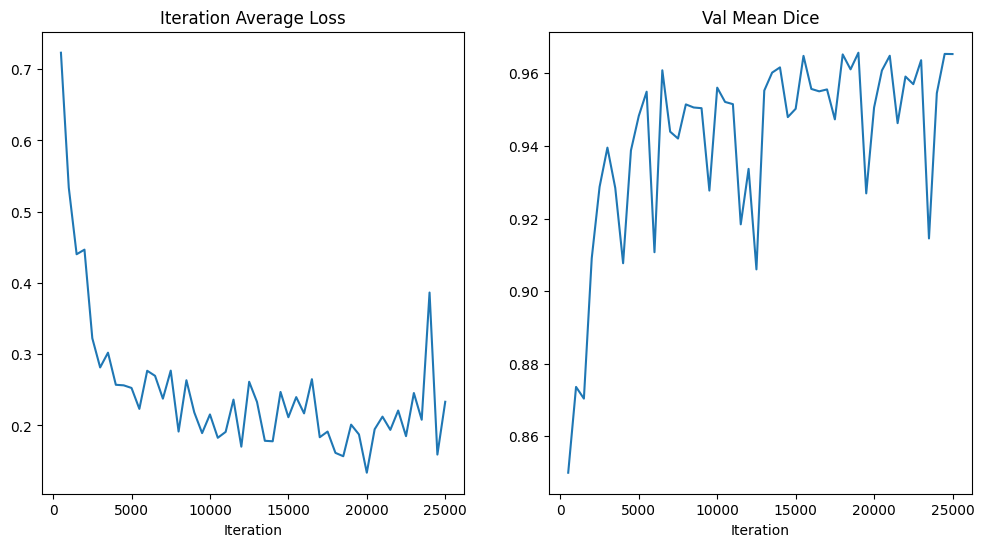

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

Check best model output with the input image and label

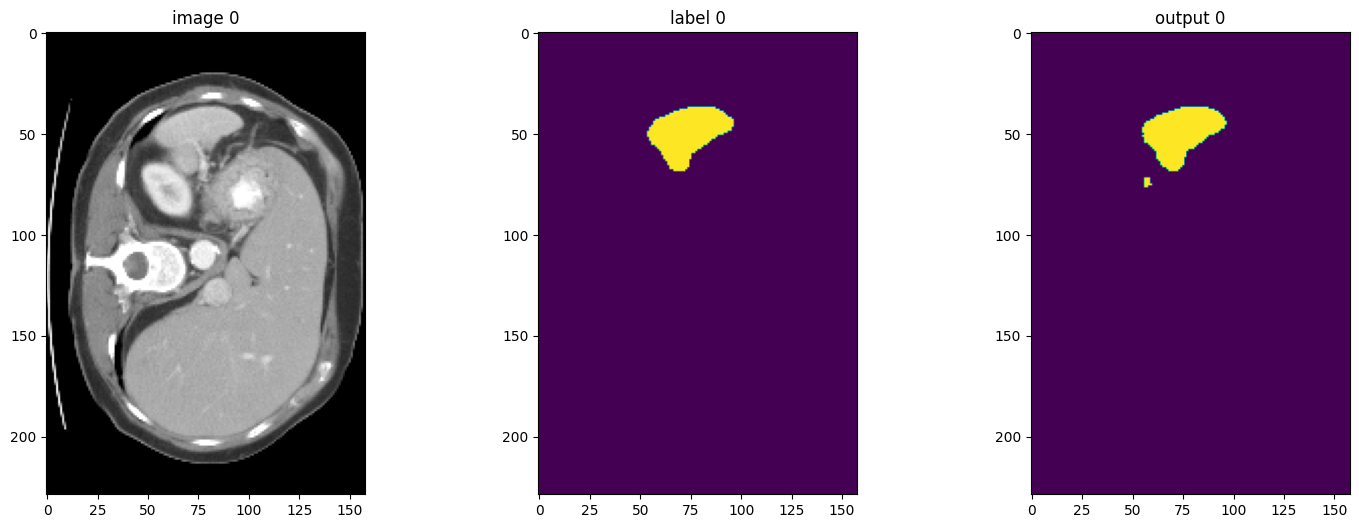

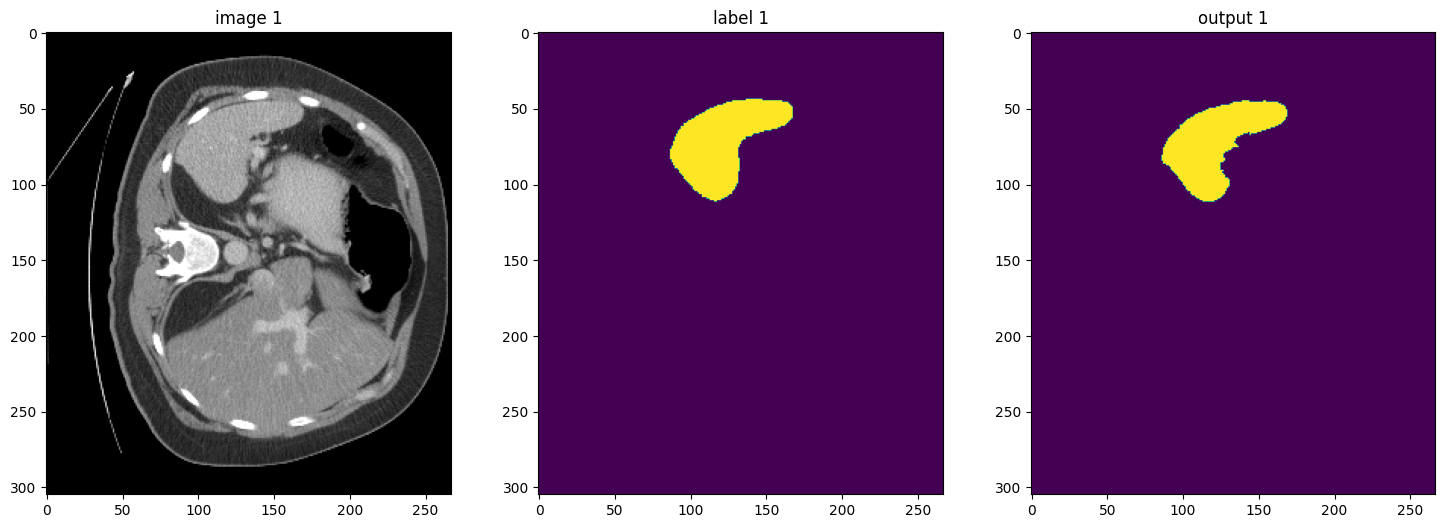

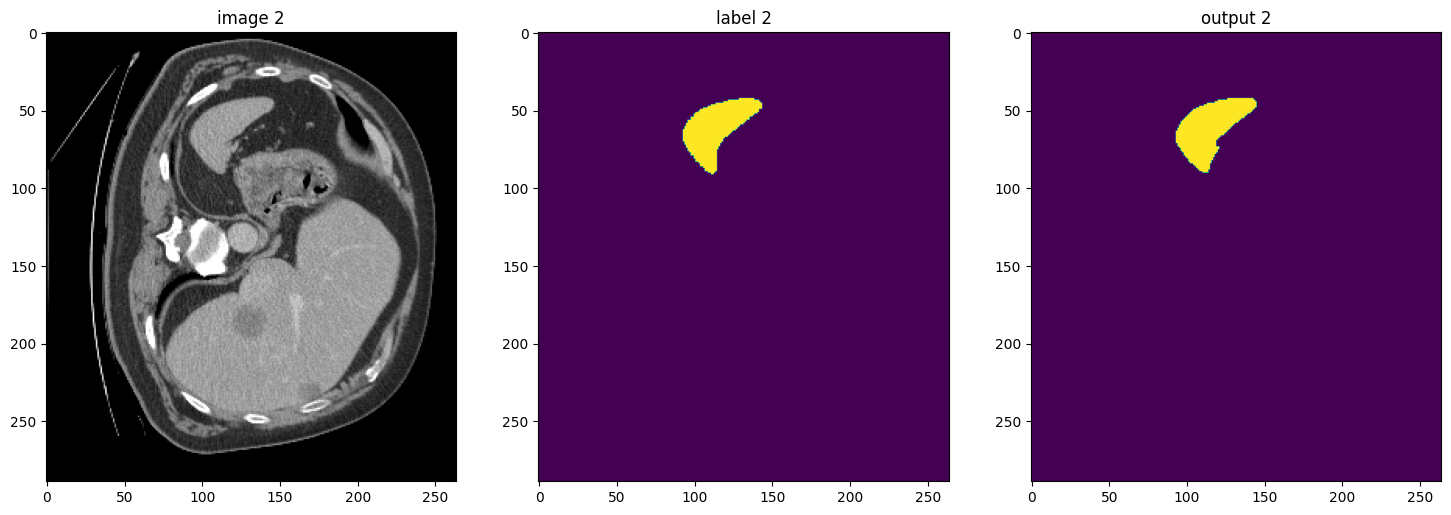

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

### Transfromation for evaluation

In [ ]:
# validation data
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [ ]:
# trainng data
train_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

train_org_ds = Dataset(data=train_files, transform=val_org_transforms)
train_org_loader = DataLoader(train_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [ ]:

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

## Evaluation

In [ ]:
#original validation data
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.load_state_dict(torch.load(os.path.join(path, "unetr_best_metric_model.pth")))

model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.9462450742721558


In [ ]:
#Metric on original validation image spacing:  0.9462450742721558

In [ ]:
# original trainnig data
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for train_data in train_org_loader:
        train_inputs = train_data["image"].to(device)
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        train_data["pred"] = sliding_window_inference(train_inputs, roi_size, sw_batch_size, model)
        train_data = [post_transforms(i) for i in decollate_batch(train_data)]
        train_outputs, train_labels = from_engine(["pred", "label"])(train_data)
        # compute metric for current iteration
        dice_metric(y_pred=train_outputs, y=train_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.9479564428329468


In [ ]:
#Metric on original trainng image spacing:  0.9479564428329468

Cleanup data directory

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)